# Arshnoor Singh Sachdeva
## Project-1: Rocket Landing Problem
### 1222482300

# Problem Formulation:

##States of the system:
*   x = x-coordinate of the rocket
*   y = y-coordinate of the rocket
*   $v_x$ = x-component of rocket velocity
*   $v_y$ = y-component of rocket velocity
*   $\theta$ = heading angle of the rocket

$$State\; Vector = \begin{bmatrix} x \\ y \\ v_x \\ v_y \\ \theta \end{bmatrix} ,\; a = \begin{bmatrix} a_{thrust} \\ \dot \theta  \end{bmatrix}$$

Forces considered during the formulation of the problem:


*   Gravitational Force: Acting in negative-y direction
*   Thrust Force: Acting in positive-y direction
*   Drag Force: Acting opposite to vertical velocity of the rocket (Assumed for this project. It usually acts opposite to the velocity)

Goal Conditions for the Landing condition:
$\begin{bmatrix} x \\ y \\ v_x \\ v_y \\ \theta \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}$


## Forces of the Model:

Drag Force ($F_{drag}$) = $ \rho * A * v^2 * C_d$   
where,
$$\rho = Density\;  of \; medium \; (Air),\;\\ A = Cross\;section\; area ,\;\\ v = Vertical \; velocity\; (v_y) \\ ,\;C_d = Drag\; Coefficient$$

Gravitational Force acts in the '-y' direction and is equal to the weight of the rocket.

Thrust force is the force exerted by the propulsion system of the rocket.




##  Discrete Dynamics of the Model:

The updated state at the next time step $s[t+1]$ is given by:

$$\begin{bmatrix} x[t+1] \\ y[t+1] \\ v_x[t+1] \\ v_y[t+1] \\ \theta[t+1] \end{bmatrix} = \begin{bmatrix} x[t] + v_x[t]*\Delta t \\ y[t] + v_y[t]*\Delta t \\ v_x[t] + a_{thrust}*cos(\theta)*\Delta t \\ v_y[t] + (a_{thrust}*sin(\theta)+a_{drag} - a_{grav})*\Delta t \\ \theta[t] + \dot \theta*\Delta t \end{bmatrix}$$












## Controller Design

The control strategy used for getting acceleration due to thrust force and the angular velocity is an optimal controller. 

The closed loop control equation is 
$$ a = f_{\Theta}(s(t)) $$
where, $f_{\Theta}(\cdot)$ is a neural network.

Output of the neural network is:  $\begin{bmatrix} a_{thrust} \\ \dot \theta \end{bmatrix}$

$a_{thrust} \in [0,1]$ and $\dot \theta \in [-1,1]$



Importing all the necessary libraries for the problem.

In [142]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [143]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant in Y direction
BOOST_ACCEL = 0.18  # thrust constant
DRAG_COEFF = 1 # drag coefficient


In [144]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = thrust 
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = x_dot
        state[3] = y_dot
        state[4] = theta
        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... @cc antantantant (Prof Max Yi Ren)

        delta_state_gravity = torch.tensor([0., 0.,0., -GRAVITY_ACCEL * FRAME_TIME, 0.])

        # Thrust for N initial state
        N = len(state)
        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 2] = torch.cos(state[0, 4])
        state_tensor[0, 3] = torch.sin(state[0, 4])

        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, 1.],dtype=torch.float32),(action[0, 1]).reshape(-1, 1)) 

        # Drag
        # Note: Same reason as above. Need a 2-by-1 tensor.
        v = torch.matmul(state,torch.tensor([0., 0., 0., 1., 0.]))
        delta_state_drag =DRAG_COEFF * v * v * FRAME_TIME * torch.tensor([0., 0., 0.,1., 0.])
    
        state = state + delta_state  + delta_state_gravity + delta_state_theta + delta_state_drag

        # Update state
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1.,0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        state = torch.matmul(step_mat, state.T)
            

        return state.T


In [145]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0., 0.5]))*2  # bound theta_dot range -1 to 1
        return action

In [146]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # state = [1., 0.]  # TODO: need batch of initial states
        state = [[1.,1.,0.,0.,0.5]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)


In [147]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()
    

    # Define training method for the model
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:,0]
        y = data[:,1]
        t = data[:,4]
        vx = np.square(data[:, 2])
        vy = np.square(data[:, 3])
        v = np.sqrt(vx + vy)
        
        plt.plot(y, -v)
        plt.ylabel('Velcity_y')
        plt.xlabel('Distance from ground')
        plt.show()       

[1] loss: 9.337


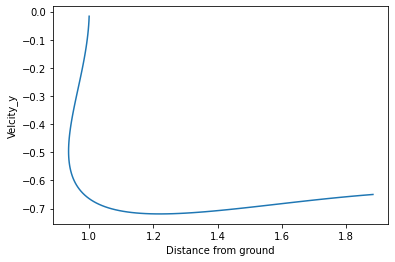

[2] loss: 4.527


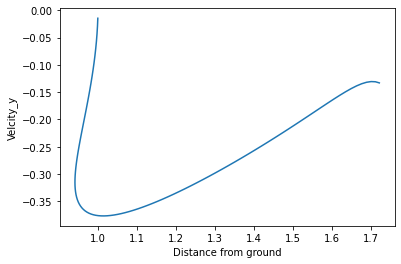

[3] loss: 3.645


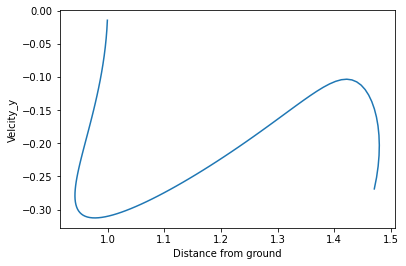

[4] loss: 3.108


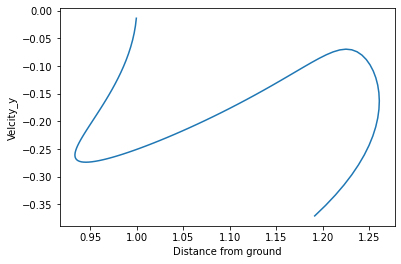

[5] loss: 2.591


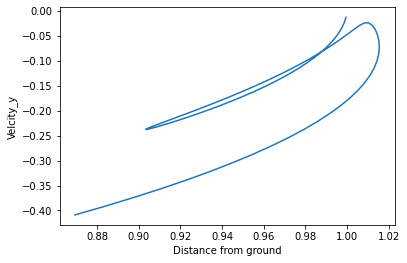

[6] loss: 1.895


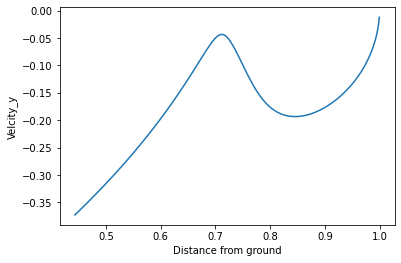

[7] loss: 1.120


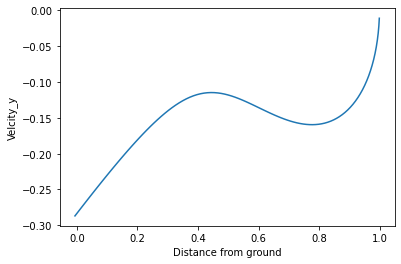

[8] loss: 0.582


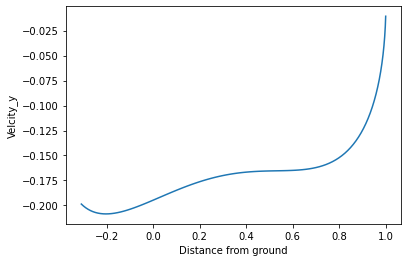

[9] loss: 0.295


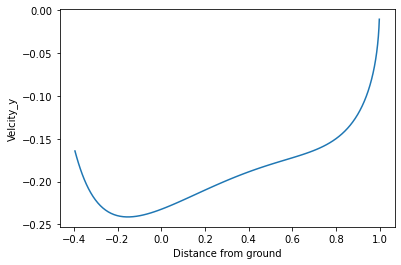

[10] loss: 0.119


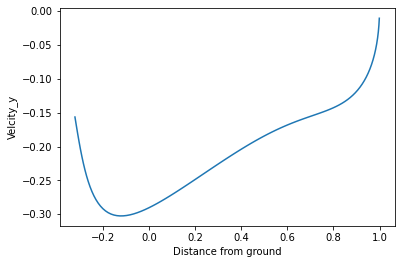

[11] loss: 0.059


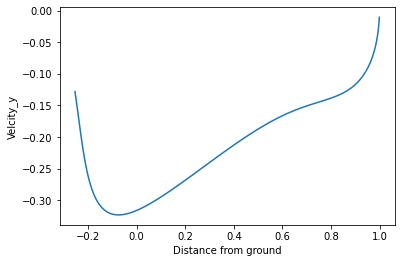

[12] loss: 0.032


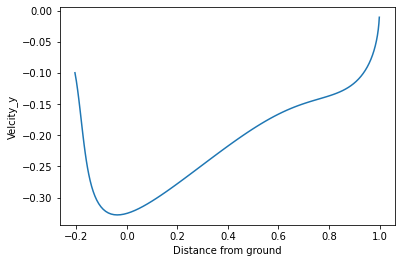

[13] loss: 0.019


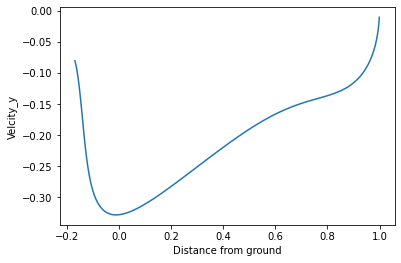

[14] loss: 0.012


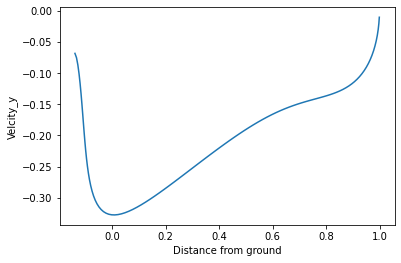

[15] loss: 0.008


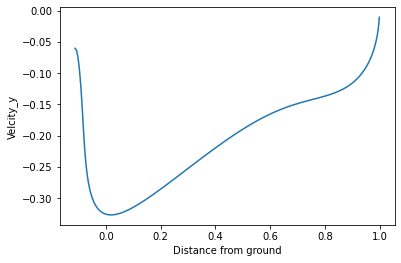

[16] loss: 0.005


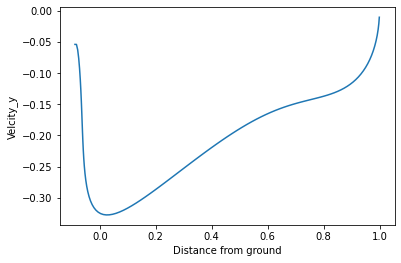

[17] loss: 0.003


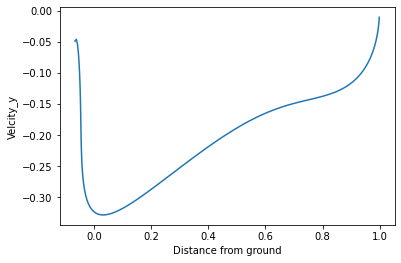

[18] loss: 0.002


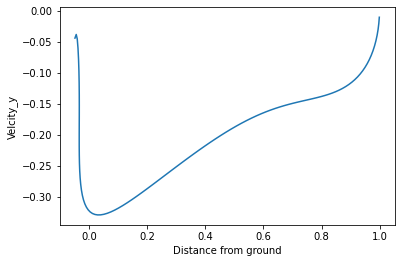

[19] loss: 0.001


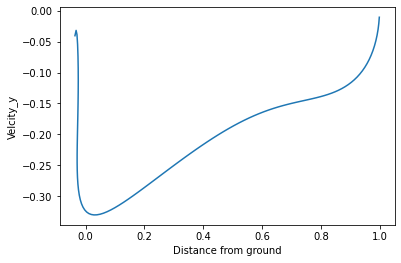

[20] loss: 0.001


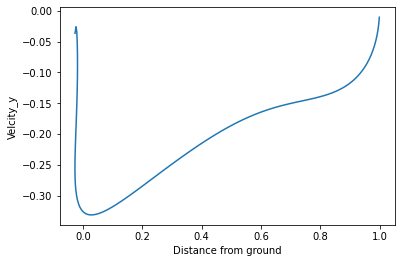

[21] loss: 0.001


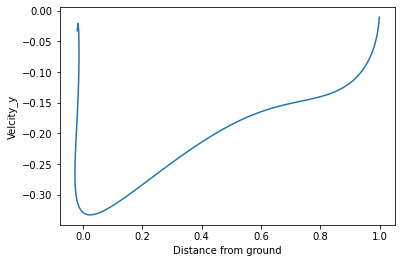

[22] loss: 0.000


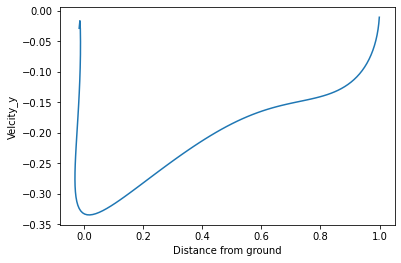

[23] loss: 0.000


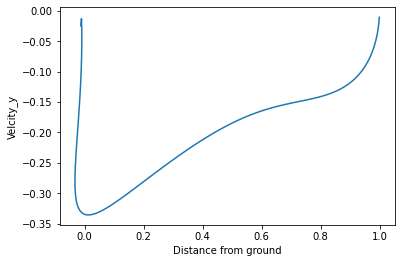

[24] loss: 0.000


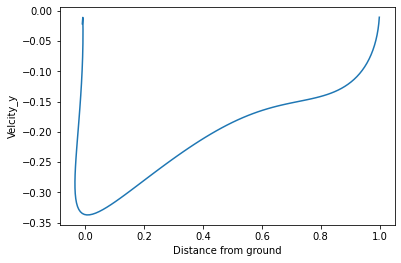

[25] loss: 0.000


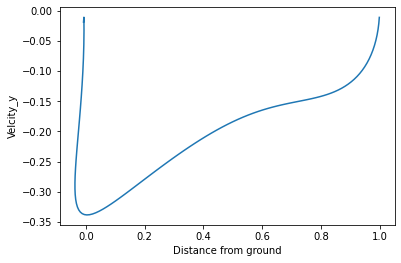

[26] loss: 0.000


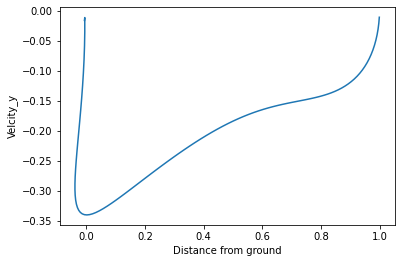

[27] loss: 0.000


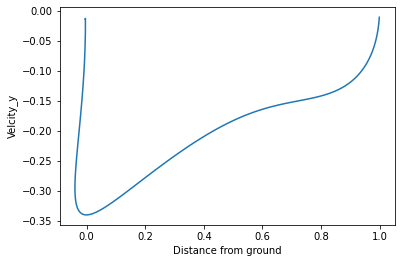

[28] loss: 0.000


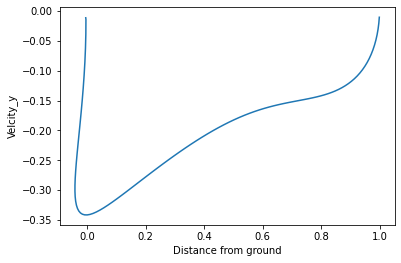

[29] loss: 0.000


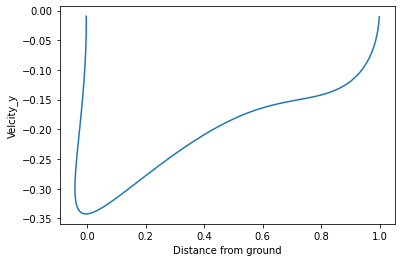

[30] loss: 0.000


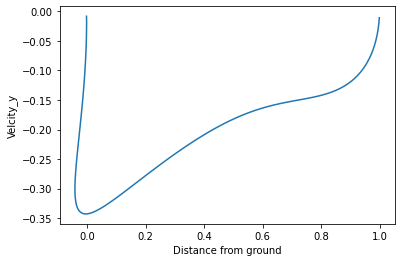

In [148]:
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(30)  # training with number of epochs